In [2]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt

In [3]:
RANDOM_STATE = 2024

In [4]:
test_data = pd.read_csv('test.csv')
test_data = test_data.drop('description', axis=1)

In [5]:
train_data = pd.read_csv('train.csv')
sampled_data = pd.read_csv('sampled_data.csv')

In [6]:
ending_date = pd.to_datetime('2024-11-23')
# def time_handling(df, ending_date = ending_date):
#     df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
#     df['days_hosting'] = (ending_date - df['host_since']).dt.days
#     df = df.drop('host_since', axis=1)
#     return df

def time_handling(df, ending_date=pd.to_datetime('2024-11-23')):
    df['host_since'] = pd.to_datetime(df['host_since'], errors='coerce')
    days_hosting = (ending_date - df['host_since']).dt.days
    df['hosting_category'] = pd.cut(
        days_hosting,
        bins=[-float('inf'), 365, 3*365, float('inf')],  # Year thresholds
        labels=[0, 1, 2]  # Encoded values
    ).astype(int)
    
    # Drop the original 'host_since' column
    df = df.drop('host_since', axis=1)
    
    return df


In [7]:
def review_feature_handling(df, ending_date = ending_date):
    df['first_review'] = pd.to_datetime(df['first_review'], errors='coerce')
    df['last_review'] = pd.to_datetime(df['last_review'], errors='coerce')
    # df['days_since_first_review'] = (ending_date - df['first_review']).dt.days
    # df['days_since_last_review'] = (ending_date - df['last_review']).dt.days
    # df['days_since_first_review'] = df['days_since_first_review'].fillna(0)
    # df['days_since_last_review'] = df['days_since_last_review'].fillna(0)
    days_since_first_review = (ending_date - df['first_review']).dt.days
    days_since_last_review = (ending_date - df['last_review']).dt.days
    df['first_review_category'] = pd.cut(
        days_since_first_review,
        bins=[-float('inf'), 365, 3*365, float('inf')],  # Year thresholds
        labels=[0, 1, 2]
    ).fillna(0).astype(int)  # Fill NaN with 0 for missing first reviews

    df['last_review_category'] = pd.cut(
        days_since_last_review,
        bins=[-float('inf'), 365, 3*365, float('inf')],  # Year thresholds
        labels=[0, 1, 2]
    ).fillna(0).astype(int)
    df = df.drop(columns=['first_review', 'last_review'])
    review_columns = [
    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
    'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
    'review_scores_value', 'reviews_per_month', 'reviews']
    df['missing_reviews'] = df[review_columns].isnull().any(axis=1)
    df[review_columns] = df[review_columns].fillna(0)
    return df

In [8]:
def map_host_response_time(df):
    response_time_mapping = {
    'within an hour': 0,
    'within a few hours': 1,
    'within a day': 2,
    'a few days or more': 3
}
    df['host_response_time_encoded'] = df['host_response_time'].map(response_time_mapping)
    # df = df.drop('host_response_time', axis=1)
    return df

In [9]:
# used by host_response_rate, host_acceptance_rate, bedrooms, beds, bathrooms
def fill_with_median(df, columns):
    for column in columns:
        if df[column].isnull().sum() > 0:
            if df[column].dtype in ['float64', 'int64']:
                global_mode = df[column].median()
                df[column] = df[column].fillna(global_mode)
    return df

In [10]:
# def fill_with_median_train(df, columns):
#     for column in columns:
#         if df[column].isnull().sum() > 0:
#             if df[column].dtype in ['float64', 'int64']:
#                 df[column] = df[column].groupby('price')[column].transform(
#                     lambda x: x.fillna(x.median()))
#     return df

In [11]:
def host_verification_handle(df):
    df['host_verifications'] = df['host_verifications'].apply(lambda x: len(x) if isinstance(x, list) else 0)
    return df

In [12]:
def get_log_model(sampled_data):
    features = [
    'host_response_rate', 'host_acceptance_rate',
    'host_listings_count', 'host_total_listings_count', 'host_verifications',
    'host_has_profile_pic', 'host_identity_verified', 'host_response_time_encoded'
    ]
    scaler = MinMaxScaler()
    sampled_data[features] = scaler.fit_transform(sampled_data[features])
    X = sampled_data[features]
    y = sampled_data['host_is_superhost']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
    model = LogisticRegression(random_state=RANDOM_STATE, max_iter=500, class_weight='balanced')
    model.fit(X_train, y_train)
    return model, scaler

In [13]:
def host_is_superhost_handle(df, model, scaler):
    features = [
    'host_response_rate', 'host_acceptance_rate',
    'host_listings_count', 'host_total_listings_count', 'host_verifications',
    'host_has_profile_pic', 'host_identity_verified', 'host_response_time_encoded'
    ]
    missing_indices = df[df['host_is_superhost'].isnull()].index
    X_missing = df.loc[missing_indices, features]
    # missing_values_new = X_missing.isnull().sum()
    # print(missing_values_new)
    bool_features_pred = ['host_identity_verified', 'host_has_profile_pic']
    X_missing[bool_features_pred] = X_missing[bool_features_pred].astype(int)
    numerical_features = features
    X_missing[numerical_features] = scaler.transform(X_missing[numerical_features])
    predicted_values = model.predict(X_missing)
    predicted_values = ['TRUE' if val == 1 else 'FALSE' for val in predicted_values]
    df.loc[missing_indices, 'host_is_superhost'] = predicted_values

    return df

In [14]:
# remove 'has_availability' and 'bathrooms_text'

In [15]:
def pre_pocessing_test_data(df):
    df = time_handling(df)
    df = review_feature_handling(df)
    df = map_host_response_time(df)
    median_columns = ['host_response_rate', 'host_acceptance_rate', 'bedrooms', 'beds', 'bathrooms']
    df['host_response_time_encoded'] = df['host_response_time_encoded'].fillna(0)
    df = fill_with_median(df, median_columns)
    df = host_verification_handle(df)
    model, scaler = get_log_model(sampled_data)
    df = host_is_superhost_handle(df, model, scaler)
    columns_to_drop = ['bathrooms_text', 'host_response_time', 'reviews']
    df = df.drop(columns_to_drop, axis=1)
    return df

In [16]:
processed_test_data = pre_pocessing_test_data(test_data)

In [17]:
processed_test_data = processed_test_data.drop(['name'], axis = 1)

In [18]:
processed_train_data = pre_pocessing_test_data(train_data)
processed_train_data = processed_train_data.drop(['name'], axis = 1)
processed_train_data = processed_train_data.drop(['description'], axis = 1)

In [19]:
def map_property_type(df):
    property_type_counts = df['property_type'].value_counts()
    rare_threshold = 200
    df['property_type'] = df['property_type'].apply(
    lambda x: x if property_type_counts[x] >= rare_threshold else 'Other'
    )
    property_type_ranking = {
    'Private room in home': 1,
    'Private room in rental unit': 2,
    'Private room in townhouse': 3,
    'Private room in condo': 4,
    'Room in hotel': 5,
    'Entire rental unit': 6,
    'Entire condo': 7,
    'Entire townhouse': 8,
    'Entire home': 9,
    'Other': 10
    }
    df['property_type_encoded'] = df['property_type'].map(property_type_ranking)
    df = df.drop('property_type', axis=1)
    return df

In [20]:
def map_room_type(df):
    room_type_ranking = {
    'Shared room': 1,
    'Private room': 2,
    'Hotel room': 3,
    'Entire home/apt': 4
    }
    df['room_type_encoded'] = df['room_type'].map(room_type_ranking)
    df = df.drop('room_type', axis=1)
    return df

In [21]:
import ast
def calculate_amenities(amenities):
    try:
        amenities_list = ast.literal_eval(amenities) if isinstance(amenities, str) else []
        return len(amenities_list)
    except:
        return 0
    

In [22]:
def neighbourhood_handling(df):
    neighbourhood_ranking = {
    'Staten Island': 1,
    'Bronx': 2,
    'Queens': 3,
    'Brooklyn': 4,
    'Manhattan': 5
    }
    df['neighbourhood_group_encoded'] = df['neighbourhood_group_cleansed'].map(neighbourhood_ranking)
    df = df.drop(['neighbourhood_group_cleansed', 'neighbourhood_cleansed'], axis=1)
    return df

In [23]:
def type_conversion(df):
    conversion_list = ['host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 
                   'missing_reviews', 'host_is_superhost', 'has_availability']
    for col in conversion_list:
        df[col] = df[col].apply(lambda x: 1 if x == 'TRUE' else 0)
    return df

In [24]:
def shallow_engineering_wrapper(df):
    df = map_property_type(df)
    df = map_room_type(df)
    df['amenity_score'] = df['amenities'].apply(calculate_amenities)
    df = df.drop('amenities', axis=1)
    df = neighbourhood_handling(df)
    df = type_conversion(df)
    return df

In [25]:
shallow_engineered_test_data = shallow_engineering_wrapper(processed_test_data)

In [26]:
eng_train_data = shallow_engineering_wrapper(processed_train_data)
# print(eng_train_data.dtypes)

In [27]:
# training_data = pd.read_csv('./processed_train.csv')

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [127]:
# from sklearn.inspection import permutation_importance
# import matplotlib.pyplot as plt
# perm_importance = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE)

# # Display feature importance
# feature_importance = pd.DataFrame({
#     'Feature': X_test.columns,
#     'Importance': perm_importance.importances_mean
# }).sort_values(by='Importance', ascending=False)

# print("\nPermutation Feature Importance:")
# print(feature_importance)

# # Plot feature importance
# plt.figure(figsize=(10, 10))
# plt.barh(feature_importance['Feature'], feature_importance['Importance'])
# plt.gca().invert_yaxis()
# plt.title('Permutation Feature Importance')
# plt.xlabel('Mean Importance')
# plt.ylabel('Feature')
# plt.show()

In [112]:
training_data.head(5)

,Unnamed: 0,price,latitude,longitude,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,...,reviews_per_month,missing_reviews,days_hosting,days_since_first_review,days_since_last_review,host_response_time_encoded,property_type_encoded,room_type_encoded,amenity_score,neighbourhood_group_encoded
0,0,4,40.684560,-73.939870,100.0,100.0,0,2.0,2.0,2,...,0.52,0,3472,2036.0,105.0,2.0,6,4,32,4
1,1,3,40.638991,-73.965739,100.0,98.0,0,1.0,1.0,2,...,3.81,0,436,315.0,82.0,0.0,2,2,37,4
2,2,3,40.618810,-74.032380,100.0,100.0,0,52.0,55.0,2,...,2.14,0,846,149.0,98.0,0.0,6,4,34,4
3,3,0,40.673970,-73.953990,99.0,23.0,0,727.0,1336.0,2,...,0.00,0,4487,0.0,0.0,0.0,2,2,14,4
4,4,2,40.747180,-73.985390,93.0,95.0,0,707.0,2453.0,2,...,0.00,0,3623,0.0,0.0,0.0,5,3,24,5


In [115]:
X_real = shallow_engineered_test_data.drop('id',axis=1)
X_real[numerical_features] = scaler.transform(X_real[numerical_features])

In [118]:
X_real = X_real[X_train.columns]

In [119]:
y_real = best_model.predict(X_real)

In [121]:
id_column = shallow_engineered_test_data['id']
combined_df = pd.DataFrame({
    'id': id_column,
    'price': y_real
})
combined_df.to_csv('predictions.csv', index=False)

In [49]:
from xgboost import XGBClassifier
loaded_classifier = XGBClassifier()
loaded_classifier.load_model('booster_classifier.json')

In [50]:
X_pred = shallow_engineered_test_data.drop('id',axis=1)

In [53]:
len(X_pred.columns)

46

In [42]:
from sklearn.cluster import KMeans
def get_modified_data(orig_data):
    modified_data = orig_data.copy()
    modified_data['weighted_availability'] = (
        0.7 * orig_data['availability_90'] + 
        0.2 * orig_data['availability_60'] + 
        0.1 * orig_data['availability_30']
    )

    modified_data['log_minimum_nights'] = np.log1p(modified_data['minimum_nights'])
    modified_data['min_nights_accommodates_interaction'] = modified_data['minimum_nights'] * modified_data['accommodates']

    geo_features = orig_data[['longitude', 'latitude']]
    kmeans = KMeans(n_clusters=5, random_state=RANDOM_STATE+1)

    modified_data['location_cluster'] = kmeans.fit_predict(geo_features)
    weights = {
        'review_scores_location': 0.8,
        'review_scores_cleanliness': 0.1,
        'review_scores_communication': 0,
        'review_scores_checkin': 0.1,
        'review_scores_value': 0,
        'review_scores_accuracy': 0
    }

    modified_data['weighted_review_score'] = (
        modified_data['review_scores_location'] * weights['review_scores_location'] +
        modified_data['review_scores_cleanliness'] * weights['review_scores_cleanliness'] +
        modified_data['review_scores_communication'] * weights['review_scores_communication'] +
        modified_data['review_scores_checkin'] * weights['review_scores_checkin'] +
        modified_data['review_scores_value'] * weights['review_scores_value'] +
        modified_data['review_scores_accuracy'] * weights['review_scores_accuracy']
    )

    modified_data['availability_acceptance_interaction'] = (
        modified_data['weighted_availability'] * orig_data['host_acceptance_rate']
    )
    return modified_data

In [372]:
modified_data = get_modified_data(shallow_engineered_test_data)

d:\Tools\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [43]:
modified_data_train = get_modified_data(eng_train_data)

d:\Tools\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [52]:
from sklearn.ensemble import GradientBoostingClassifier

# X = modified_data_train.drop(columns=['price'])
# y = modified_data_train['price']

X = eng_train_data.drop(columns=['price'])
y = eng_train_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

model_xgb = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)
param_grid = {
    'max_depth': [5,6,7],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [250, 300],
    # 'subsample': [0.8],
    # 'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)
y_pred_rounded = np.clip(y_pred_rounded, 0, None)

print("Accuracy:", accuracy_score(y_test, y_pred_rounded))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rounded))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
print("\nRoot Mean Squared Error (RMSE):", rmse)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Accuracy: 0.5697452229299363

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.69      0.78       539
           1       0.50      0.47      0.48       537
           2       0.39      0.50      0.44       508
           3       0.48      0.61      0.54       557
           4       0.49      0.48      0.49       477
           5       0.87      0.65      0.75       522
           6       0.00      0.00      0.00         0

    accuracy                           0.57      3140
   macro avg       0.52      0.49      0.50      3140
weighted avg       0.60      0.57      0.58      3140


Root Mean Squared Error (RMSE): 0.7894608335081051


d:\Tools\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Tools\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Tools\miniconda\Lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [53]:
X_real = shallow_engineered_test_data.drop('id',axis=1)
X_real = X_real[X_train.columns]
y_real = best_model.predict(X_real)
y_real_rounded = np.round(y_real).astype(int)
y_real_rounded = np.clip(y_real_rounded, 0, None)


In [54]:
id_column = shallow_engineered_test_data['id']
combined_df = pd.DataFrame({
    'id': id_column,
    'price': y_real_rounded
})
combined_df.to_csv('predictions_reg0.csv', index=False)

In [45]:
from sklearn.ensemble import GradientBoostingClassifier

X = modified_data_train.drop(columns=['price'])
y = modified_data_train['price']

# X = eng_train_data.drop(columns=['price'])
# y = eng_train_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

model_xgb = XGBRegressor(objective='reg:squarederror', random_state=RANDOM_STATE)
param_grid = {
    'max_depth': [7, 8,9],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [200, 250, 300],
    # 'subsample': [0.8],
    # 'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_rounded = np.round(y_pred).astype(int)
y_pred_rounded = np.clip(y_pred_rounded, 0, None)

print("Accuracy:", accuracy_score(y_test, y_pred_rounded))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rounded))
rmse = np.sqrt(mean_squared_error(y_test, y_pred_rounded))
print("\nRoot Mean Squared Error (RMSE):", rmse)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best Parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 250}
Accuracy: 0.5687898089171974

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.71      0.78       539
           1       0.52      0.50      0.51       537
           2       0.40      0.49      0.44       508
           3       0.46      0.57      0.51       557
           4       0.47      0.48      0.48       477
           5       0.86      0.66      0.75       522

    accuracy                           0.57      3140
   macro avg       0.60      0.57      0.58      3140
weighted avg       0.60      0.57      0.58      3140


Root Mean Squared Error (RMSE): 0.7958891194418101


In [381]:
X_real = modified_data.drop('id',axis=1)
X_real = X_real[X_train.columns]
y_real = best_model.predict(X_real)

In [382]:
id_column = shallow_engineered_test_data['id']
combined_df = pd.DataFrame({
    'id': id_column,
    'price': y_real
})
combined_df.to_csv('predictions_mode.csv', index=False)

In [321]:
from catboost import CatBoostClassifier

X = modified_data_train.drop(columns=['price'])
y = modified_data_train['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

model_cb = CatBoostClassifier(iterations=1000, learning_rate=0.1, depth=10, verbose=0)
model_cb.fit(X_train, y_train)

y_pred = model_cb.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nRoot Mean Squared Error (RMSE):", rmse)


Accuracy: 0.5964968152866242

Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.81      0.82       539
           1       0.52      0.58      0.55       537
           2       0.47      0.45      0.46       508
           3       0.48      0.50      0.49       557
           4       0.48      0.45      0.46       477
           5       0.80      0.76      0.78       522

    accuracy                           0.60      3140
   macro avg       0.60      0.59      0.59      3140
weighted avg       0.60      0.60      0.60      3140


Root Mean Squared Error (RMSE): 0.8777141707897256


In [165]:
# modified_data_train.dtypes

In [92]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import tensorflow as tf

X = modified_data_train.drop('price', axis=1)
y = modified_data_train['price']
X = eng_train_data.drop('price', axis=1)
y = eng_train_data['price']
# categorical_columns = [col for col in X.columns if X[col].nunique() < 11]  # Example threshold
# numerical_columns = [col for col in X.columns if col not in categorical_columns]
# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", "passthrough", numerical_columns),  # Leave numerical columns as is
#         ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_columns),  # Encode categorical columns
#     ]
# )
# X_processed = preprocessor.fit_transform(X)
X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

scaler = StandardScaler()
X_train_nn = scaler.fit_transform(X_train_nn)

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_processed)
X_test_nn = scaler.transform(X_test_nn)

X_train_nn = tf.convert_to_tensor(X_train_nn, dtype=tf.float32)
X_test_nn = tf.convert_to_tensor(X_test_nn, dtype=tf.float32)
y_train_nn = tf.convert_to_tensor(y_train_nn, dtype=tf.float32)
y_test_nn = tf.convert_to_tensor(y_test_nn, dtype=tf.float32)

In [222]:
# from tensorflow.keras.utils import to_categorical

# y_one_hot = to_categorical(y, num_classes=6)

In [48]:
# import tensorflow as tf

# def rmse_bins(y_true, y_pred):
#     # Convert one-hot encoded y_true to bin indices
#     true_bins = tf.argmax(y_true, axis=1)
#     # Convert softmax probabilities y_pred to bin indices
#     pred_bins = tf.argmax(y_pred, axis=1)
#     # Compute RMSE
#     return tf.sqrt(tf.reduce_mean(tf.square(tf.cast(true_bins - pred_bins, tf.float32))))


In [76]:
X_train_nn

<tf.Tensor: shape=(12556, 52), dtype=float32, numpy=
array([[-0.6782533 , -0.7354472 , -4.0357533 , ...,  0.38300422,
         0.7295359 , -1.2004305 ],
       [ 0.58822495, -0.43631947, -2.5078557 , ..., -1.1885647 ,
        -1.5620275 ,  1.5335017 ],
       [ 0.27420738,  0.78496844,  0.3092058 , ...,  1.1687887 ,
        -1.5620275 , -0.02615836],
       ...,
       [ 0.25857863,  2.5809655 ,  0.3569526 , ..., -0.40278026,
         0.57769084,  1.2731451 ],
       [-0.74440897, -0.6273661 ,  0.3569526 , ...,  0.38300422,
         0.7003705 , -0.36563635],
       [-0.14965107, -0.3475872 ,  0.3569526 , ..., -1.1885647 ,
        -1.5620275 , -1.1045532 ]], dtype=float32)>

In [94]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LeakyReLU
# Updated Model with Leaky ReLU

model = Sequential()

# Input Layer
model.add(Dense(512, input_dim=X_train_nn.shape[1]))
model.add(LeakyReLU(alpha=0.01))  # Leaky ReLU activation
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 1
model.add(Dense(256))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Hidden Layer 2
model.add(Dense(128))
model.add(LeakyReLU(alpha=0.01))
model.add(BatchNormalization())
model.add(Dropout(0.3))

# Output Layer
model.add(Dense(1, activation='linear'))  # Linear activation for regression

# Compile
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mae']
)


d:\Tools\miniconda\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
d:\Tools\miniconda\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [96]:
# Train the model
history = model.fit(
    X_train_nn, y_train_nn,
    validation_split=0.2,  # Use 20% of training data for validation
    epochs=100,           # Number of epochs
    batch_size=32,        # Mini-batch size
    verbose=1             # Display progress
)

# Evaluate the model on the test set
# test_loss, test_mae, test_mse = model.evaluate(X_test_nn, y_test_nn, verbose=1)
# print(f"Test Loss: {test_loss:.4f}, Test MAE: {test_mae:.4f}, Test MSE: {test_mse:.4f}")

# Predict on the test set
y_pred = model.predict(X_test_nn)

# Round predictions to integers and clip negatives
y_pred_rounded = np.round(y_pred).astype(int)
y_pred_rounded = np.clip(y_pred_rounded, 0, None)  # Clip negatives to zero
rmse = np.sqrt(mean_squared_error(y_test_nn, y_pred_rounded.flatten()))
print("\nRoot Mean Squared Error (RMSE):", rmse)
# print("Rounded Predictions:", y_pred_rounded.flatten())


Epoch 1/100


314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4760 - mae: 0.5323 - val_loss: 0.6476 - val_mae: 0.6057
Epoch 2/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5039 - mae: 0.5448 - val_loss: 0.6506 - val_mae: 0.5996
Epoch 3/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5089 - mae: 0.5510 - val_loss: 0.6439 - val_mae: 0.6010
Epoch 4/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5133 - mae: 0.5560 - val_loss: 0.6550 - val_mae: 0.6076
Epoch 5/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4922 - mae: 0.5441 - val_loss: 0.6510 - val_mae: 0.6034
Epoch 6/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4823 - mae: 0.5353 - val_loss: 0.6571 - val_mae: 0.5928
Epoch 7/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4715 - mae: 0.5299 - val_loss: 0.6683 - val_mae: 0.6241
Epoch 8/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4845 - mae: 0.5359 - val_loss: 0.6538 - val_mae: 0.6066
Epoch 9/100
314/314 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

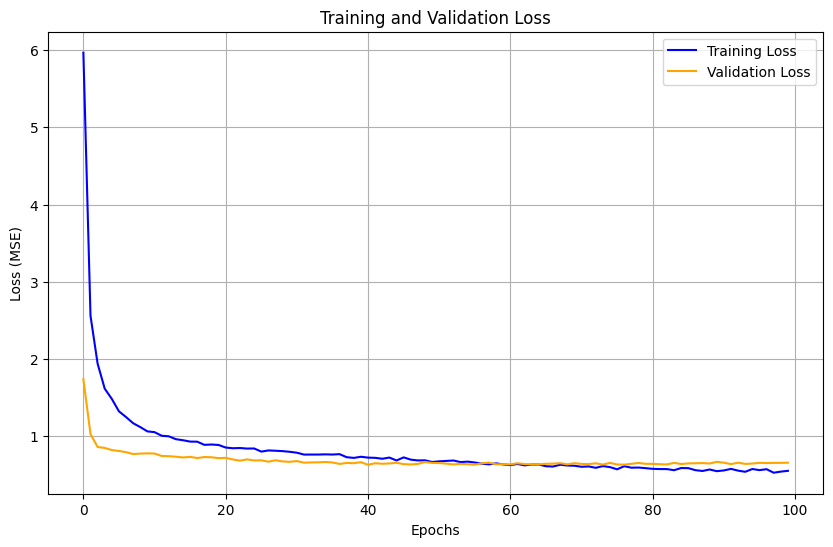

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()

In [68]:
y_test_nn

15407    0
2181     2
8038     0
5684     3
7429     1
        ..
10522    4
9183     1
9686     1
4676     2
3932     0
Name: price, Length: 3140, dtype: int64


Root Mean Squared Error (RMSE): 0.8685957625536258


In [57]:
# from tensorflow.keras.utils import to_categorical

# X_train, X_val, y_train, y_val = train_test_split(X_scaled, y, test_size=0.2, random_state=RANDOM_STATE)
# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=32)


In [186]:
logits = model.predict(X_val)
y_p = np.argmax(logits, axis=1)

99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 690us/step


In [189]:
y_val_class = np.argmax(y_val, axis=1)
rmse = np.sqrt(mean_squared_error(y_p, y_val_class))
print("\nRoot Mean Squared Error (RMSE):", rmse)


Root Mean Squared Error (RMSE): 0.9702583541950826


In [171]:
from sklearn.metrics import classification_report, accuracy_score

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate performance
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.5522292993630573
              precision    recall  f1-score   support

           0       0.71      0.82      0.76       540
           1       0.46      0.49      0.48       524
           2       0.39      0.43      0.41       513
           3       0.46      0.40      0.43       556
           4       0.47      0.43      0.45       463
           5       0.82      0.71      0.76       544

    accuracy                           0.55      3140
   macro avg       0.55      0.55      0.55      3140
weighted avg       0.56      0.55      0.55      3140



In [162]:
X = modified_data_train.drop(columns=['price'])
y = modified_data_train['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# scaler = MinMaxScaler()

# X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
# X_test[numerical_features] = scaler.transform(X_test[numerical_features])

model_xgb = XGBClassifier(objective='reg:squarederror', num_class=y.nunique(), random_state=RANDOM_STATE)
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.1],
    'n_estimators': [200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}
grid_search = GridSearchCV(estimator=model_xgb, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nRoot Mean Squared Error (RMSE):", rmse)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Accuracy: 0.6184713375796178

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.83      0.83       539
           1       0.55      0.61      0.57       537
           2       0.51      0.47      0.49       508
           3       0.50      0.55      0.52       557
           4       0.52      0.46      0.49       477
           5       0.80      0.78      0.79       522

    accuracy                           0.62      3140
   macro avg       0.62      0.62      0.62      3140
weighted avg       0.62      0.62      0.62      3140


Root Mean Squared Error (RMSE): 0.8442386235556774


In [130]:
modified_data = eng_train_data.copy()

# Select the features for clustering
geo_features = train_data[['longitude', 'latitude']]

# Apply K-Means clustering with 5 clusters
kmeans = KMeans(n_clusters=5, random_state=42)

modified_data['location_cluster'] = kmeans.fit_predict(geo_features)
X = modified_data.drop(columns=['price'])
y = modified_data['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)

testing_model = XGBClassifier(colsample_bytree = 0.8, learning_rate =  0.1, max_depth = 7, n_estimators = 200, subsample = 0.8, objective='reg:squarederror', num_class=y.nunique(), random_state=RANDOM_STATE)
testing_model.fit(X_train, y_train)
y_pred = testing_model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("\nRoot Mean Squared Error (RMSE):", rmse)

d:\Tools\miniconda\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)



Root Mean Squared Error (RMSE): 0.8590099470739407


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [26]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # First hidden layer
        self.relu1 = nn.ReLU()
        # self.fc2 = nn.Linear(128, 64)  # Second hidden layer
        # self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, output_size)  # Output layer
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        # x = self.fc2(x)
        # x = self.relu2(x)
        x = self.fc3(x)
        return x

In [27]:
nn_model = torch.load('nn_model.pth')

In [28]:
modified_data

,id,latitude,longitude,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,...,property_type_encoded,room_type_encoded,amenity_score,neighbourhood_group_encoded,weighted_availability,log_minimum_nights,min_nights_accommodates_interaction,location_cluster,weighted_review_score,availability_acceptance_interaction
0,3917,40.744620,-73.904520,100.0,91.0,0,1.0,12.0,0,0,...,9,4,49,3,68.0,3.433987,180,2,4.972,6188.0
1,1885,40.753407,-73.934995,99.0,23.0,0,727.0,1336.0,0,0,...,2,2,15,3,68.0,3.433987,30,3,0.000,1564.0
2,1305,40.677090,-73.943810,100.0,91.0,0,1.0,1.0,0,0,...,10,4,10,4,68.0,3.433987,60,4,4.829,6188.0
3,19328,40.795760,-73.971570,70.0,37.0,0,36.0,79.0,0,0,...,6,4,17,5,0.0,3.433987,30,2,4.800,0.0
4,16511,40.713590,-73.955400,100.0,75.0,0,1.0,1.0,0,0,...,6,4,44,4,16.2,3.433987,60,3,4.869,1215.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6722,7205,40.637960,-73.951360,100.0,100.0,0,2.0,2.0,0,0,...,2,2,64,4,69.0,3.433987,60,4,4.712,6900.0
6723,3954,40.823720,-73.945460,0.0,33.0,0,7.0,8.0,0,0,...,2,2,13,5,0.8,3.433987,30,2,4.720,26.4
6724,1358,40.755094,-73.937260,99.0,23.0,0,727.0,1336.0,0,0,...,2,2,15,3,42.0,3.433987,30,3,0.000,966.0
6725,2793,40.781580,-73.984780,100.0,100.0,0,1.0,3.0,0,0,...,6,4,31,5,31.6,3.433987,60,3,4.850,3160.0


In [30]:
X = modified_data.copy()
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
X_test = torch.tensor(X, dtype=torch.float32)
X_test = X_test.to(torch.float32)

In [31]:
y_pred = nn_model(X_test)
y_pred

tensor([[2.8354, 2.8660, 2.8930, 2.8432, 2.9152, 2.8341],
        [3.1861, 2.9097, 3.1231, 3.0448, 3.0301, 3.0887],
        [1.2974, 1.2915, 1.3520, 1.3342, 1.3840, 1.2861],
        ...,
        [3.0325, 2.7761, 2.9778, 2.9029, 2.9037, 2.9572],
        [1.6169, 1.6223, 1.6691, 1.6439, 1.6896, 1.6089],
        [4.0472, 4.0452, 4.0600, 4.0269, 4.0618, 4.0201]],
       grad_fn=<AddmmBackward0>)